<a href="https://colab.research.google.com/github/tharinda3518/colab_developments/blob/main/PBE_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Required for First Time. Installation of pyspark, setting up Java and building Session. NOT NEEDED NOW

In [27]:

# Apache Spark uses Java, so first we must install that
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

from google.colab import drive
drive.mount('/content/drive')
!tar xzf /content/drive/MyDrive/spark-3.3.0-bin-hadoop3.tgz

# Set up environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

# Install findspark, which helps python locate the psyspark module files
!pip install -q findspark
import findspark
findspark.init()

# Import Libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql import Window
import pandas as pd
import warnings
import numpy as np
from datetime import datetime, timedelta
from sqlalchemy import create_engine
from pandas import read_csv
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, BooleanType, StringType
warnings.filterwarnings("ignore")

# Finally, we initialse a "SparkSession", which handles the computations
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("PBE_structured_FNL")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



### Install Pyspark and set Java_Home first time

In [28]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
# Import excel write module
!pip install xlsxwriter

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u392-ga-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


### Importing Required Libraries and building Spark session

In [ ]:
'''
# Import Libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql import Window
import pandas as pd
import warnings
import numpy as np
from datetime import datetime, timedelta
from sqlalchemy import create_engine
from pandas import read_csv
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, BooleanType, StringType
warnings.filterwarnings("ignore")

# Finally, we initialse a "SparkSession", which handles the computations
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("PBE_structured_FNL")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
'''

### Add py Files to sparkcontext path for distributed processing of Spark workers

In [29]:
sc = spark.sparkContext
sc.addPyFile('/content/drive/MyDrive/PBE_Code/PBE_Validations.py')
sc.addPyFile('/content/drive/MyDrive/PBE_Code/PBE_Transformation.py')

### Load supporting Notebooks

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
cd /content/drive/MyDrive/PBE_Code

/content/drive/MyDrive/PBE_Code


In [32]:
!pip install import_ipynb
import import_ipynb
from PBE_Transformation import DataProcessor
from PBE_Validations import DataValidationHandler
from Ingest_Write import SQLServerDataHandler

### **Main Method**

In [33]:
def main (write_mode='N'):
    file_path = "/content/drive/MyDrive/MUG/FileWith5Inverters - SET II.csv"


    # Create an instance of the SQLServerDataHandler class
    # Used for data Load and Write
    data_handler = SQLServerDataHandler(spark)
    result_df=data_handler.load_inverter_data(file_path) # Loading data from csv file. This will change to load data directly from DB table.

    missing_threshold=2880

    # Create an instance of the DataValidationHandler class
    # performing 1st Level Generic Validations here
    validation_handler= DataValidationHandler(spark,missing_threshold)
    df_gen_val_succeded, df_gen_val_failed = validation_handler.perform_generic_validations(result_df)

    # Create an instance of the  DataProcessor(Data Transformation) class
    # Making full data 365 along with creating dervied and inst columns
    data_transformation_handler=DataProcessor(spark)
    df_merge_ready_py=data_transformation_handler.make_full_data(df_gen_val_succeded)
    df_validate_ready=data_transformation_handler.generate_derived_inst_col(df_merge_ready_py)

    # Performing Level 2 Data validations here
    df_validated=validation_handler.validate_data_udf(df_validate_ready)
    print('Checkpoint 4')

    # Cleaning validated data here
    df_tot_cleansed=data_transformation_handler.cleaning_validated_data(df_validated)

    print('Checkpoint 5')
    # Re-execute validation to re validate records after cleansing
    df_tot_cleansed_n_validated=validation_handler.validate_data_udf(df_tot_cleansed)
    print('Checkpoint 6')

    ''' Replcing any left over record with NaN value with bfill'''
    # Convert PySpark DataFrame to Pandas DataFrame
    df_tot_cleansed_n_validated_pd = df_tot_cleansed_n_validated.toPandas()   # This should be converted to Pyspark
    print('Checkpoint 6.1')
    df_processed = data_transformation_handler.process_fillna(df_tot_cleansed_n_validated_pd)  # This should be converted to Pyspark
    print('Checkpoint 7')

    # Writing data in excel below. This will be changed to store data directly to DB tables.
    if (write_mode == 'Y'):
      path = '/content/drive/MyDrive/MUG/'
      df_gen_val_failed_pd = df_gen_val_failed.toPandas()
      df_validated_pd = df_validated.toPandas()
      export_records_to_excel(df_processed, 'S', path)
      export_records_to_excel(df_gen_val_failed_pd, 'F', path)
      export_records_to_excel(df_validated_pd, 'V', path)

    return df_tot_cleansed_n_validated, df_gen_val_failed, df_validated, result_df

### **Invoke Main Function**

In [35]:
if __name__ == "__main__":
    df_tot_cleansed_n_validated, df_gen_val_failed, df_validated, result_df = main('Y')

H1E502G5080183
H1E502G5080053
HUE502H5131149
HUE502H6S06029
HUE502H6S06023
Checkpoint 1
Checkpoint 2
Checkpoint 3
Checkpoint 4
Checkpoint 4.1
Checkpoint 4.2
Checkpoint 4.3
Checkpoint 4.4
Checkpoint 5
Checkpoint 5
Checkpoint 6
Checkpoint 6.1
Checkpoint 7


### **Output**

In [34]:
def export_records_to_excel(df_failed, is_succ_failed, location):
    """
    Export failed PySpark DataFrame records to an Excel file, creating separate sheets for each unique serial number.

    Parameters:
    - df_failed (pandas.DataFrame): Pandas DataFrame containing failed records.
    - is_succ_failed (str): Indicator ('S' for success, 'F' for failure) to determine the file name.

    Returns:
    - None
    """

    # Get the current datetime and format it
    current_datetime = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

    # Define the file_path_with_datetime based on success or failure
    if is_succ_failed == 'S':
        file_path_with_datetime = f'Success_{current_datetime}.xlsx'
    elif is_succ_failed == 'F':
        file_path_with_datetime = f'Failed_{current_datetime}.xlsx'
    elif is_succ_failed == 'V':
        file_path_with_datetime = f'Flagged_{current_datetime}.xlsx'
    else:
        raise ValueError("is_succ_failed should be 'S' for success or 'F' for failure.")

    # Append location to the file path
    file_path_with_datetime = location + file_path_with_datetime

    # Get unique serial numbers
    unique_serial_numbers = df_failed['inverter_serial_no'].unique()

    # Create an Excel writer object
    excel_writer = pd.ExcelWriter(file_path_with_datetime, engine='xlsxwriter')

    # Loop through each unique serial number
    for serial_number in unique_serial_numbers:
        # Filter the DataFrame for the current serial number
        processed_df_pd_failed_tmp = df_failed[df_failed['inverter_serial_no'] == serial_number]

        # Write the filtered DataFrame to a new sheet
        sheet_name = f'inv_{serial_number}'
        processed_df_pd_failed_tmp.to_excel(excel_writer, sheet_name=sheet_name, index=False)

    # Save the Excel file
    excel_writer.save()

# EDA

In [36]:
# Import libariries needed for EDA
import seaborn as sns
import matplotlib.pyplot as plt


In [37]:
# Convert PySpark DataFrame to Pandas DataFrame
eda_df_pd = df_tot_cleansed_n_validated.toPandas()
# Add hour column for analysis purposes
eda_df_pd['hour'] = eda_df_pd['date_time'].dt.hour

## Data points

In [38]:
class DataPointsVisualizer:
    def __init__(self, data):
        self.data = data

    def plot_outliers_boxplot(self, columns):
        plt.figure(figsize=(12, 4))
        sns.boxplot(data=self.data[columns])
        plt.title('Identifying Outliers')
        plt.xticks(rotation=45, ha='right')
        plt.style.use('ggplot')
        plt.show()

    @staticmethod
    def plot_zero_counts(data):
        # Count the number of zeros in each column
        zero_counts = (data == 0).sum()

        # Plotting the count of zeros for each column
        plt.figure(figsize=(10, 6))
        zero_counts.plot(kind='bar')
        plt.title('Count of Zero Values in Each Column')
        plt.xlabel('Column')
        plt.ylabel('Count of Zeros')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_average_error_counts(df_validated):
        # Filter the DataFrame by is_valid == False
        filtered_df = df_validated.filter(df_validated.is_valid == False)

        # Grouping and aggregating the count of occurrences for each error message
        error_counts = filtered_df.groupBy('error_message').count().toPandas()

        # Calculate the average count of occurrences for each error message
        average_error_counts = error_counts.groupby(['error_message'])['count'].mean()

        # Plotting the average occurrences of each error message as a horizontal bar plot
        average_error_counts.plot(kind='barh')  # Use horizontal bar plot instead of vertical bar plot
        plt.title('Average Occurrences of Each Error Message')
        plt.xlabel('Average Count')
        plt.ylabel('Error Message')
        plt.tight_layout()

        # Adjust the layout to make room for long x-labels
        plt.subplots_adjust(left=0.3)  # Adjust left margin to make room for long x-labels

        plt.show()

    @staticmethod
    def plot_validation_proportion(df_validated):
        # Grouping and aggregating the count of is_valid values (True or False) for each inverter_serial_no
        valid_counts = df_validated.groupby(['inverter_serial_no', 'is_valid']).count().toPandas()

        # Pivot the DataFrame to have is_valid as columns
        valid_counts_pivot = valid_counts.pivot(index='inverter_serial_no', columns='is_valid', values='count')

        # Plotting the proportion of is_valid values for each inverter_serial_no
        valid_counts_pivot.plot(kind='bar', stacked=True, figsize=(12, 6))
        plt.title('Proportion of validation pass/fail for Each Inverter Serial No')
        plt.xlabel('Inverter Serial No')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_missing_data(df, PlotTitle):
        # Convert the 'date_time' column to a pandas datetime object
        df['date_time'] = pd.to_datetime(df['date_time'])

        # Set 'date_time' as the index of the DataFrame
        df.set_index('date_time', inplace=True)

        # Generate a date range covering the entire one-year period, with half-hourly frequency
        full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='30T')

        # Identify missing dates by comparing the full date range with the actual dates in the DataFrame
        missing_dates = full_date_range[~full_date_range.isin(df.index)]

        # Plotting the presence or absence of data for each half-hour interval
        plt.figure(figsize=(15, 5))
        plt.plot(df.index, df.index.isin(df.index), marker='o', markersize=3, linestyle='None', color='blue', label='Available Data')
        plt.plot(missing_dates, [False] * len(missing_dates), marker='o', markersize=3, linestyle='None', color='red', label='Missing Data')
        plt.title('Presence or Absence of Data for Overall Dataset ' + PlotTitle)
        plt.xlabel('Month')
        plt.ylabel('Data Availability')
        plt.xticks(pd.date_range(start=df.index.min(), end=df.index.max(), freq='M'), [d.strftime('%b %Y') for d in pd.date_range(start=df.index.min(), end=df.index.max(), freq='M')], rotation=45)
        plt.yticks([0, 1], ['Missing', 'Available'])
        plt.legend()
        plt.tight_layout()
        plt.show()



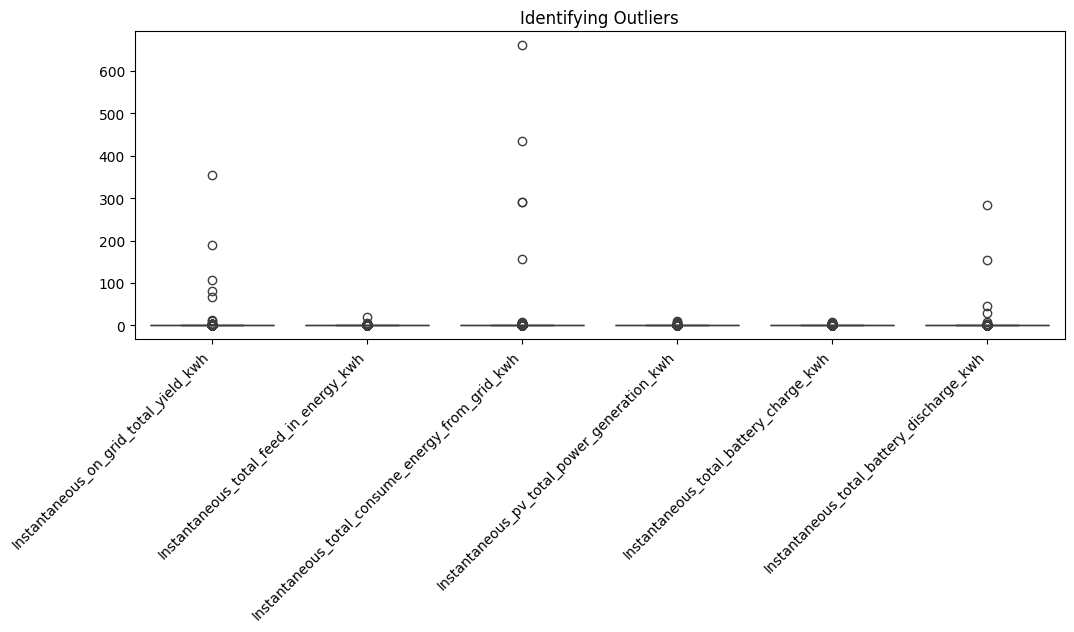

In [39]:
selected_columns = ['Instantaneous_on_grid_total_yield_kwh',
                    'Instantaneous_total_feed_in_energy_kwh',
                    'Instantaneous_total_consume_energy_from_grid_kwh',
                    'Instantaneous_pv_total_power_generation_kwh',
                    'Instantaneous_total_battery_charge_kwh',
                    'Instantaneous_total_battery_discharge_kwh']

data_visualizer = DataPointsVisualizer(eda_df_pd)
data_visualizer.plot_outliers_boxplot(selected_columns)

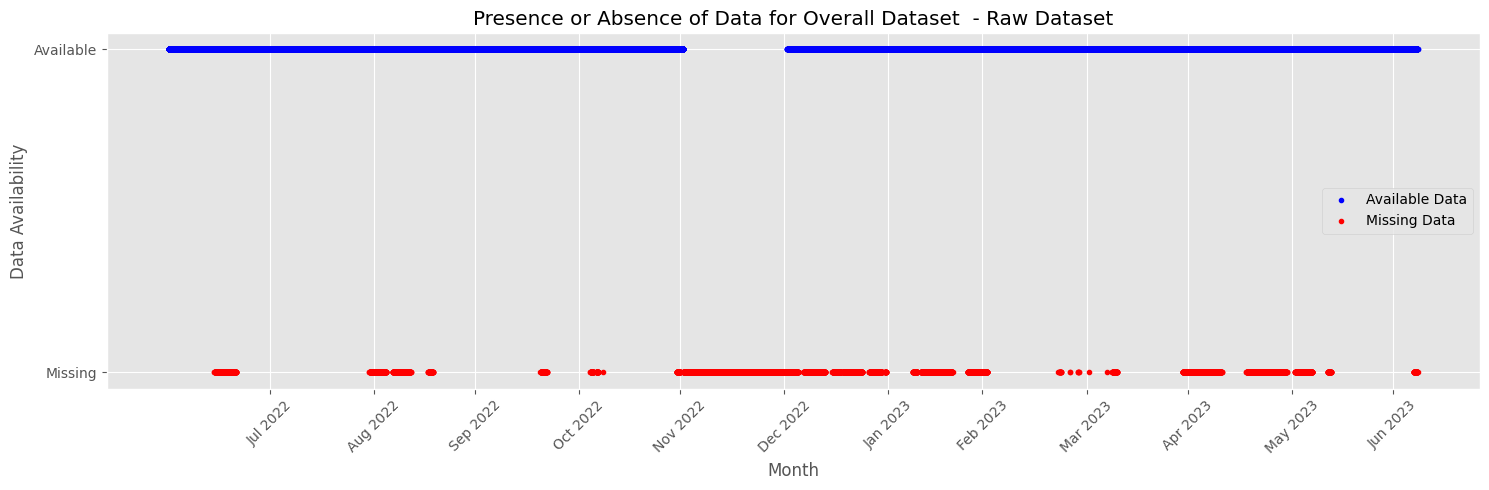

In [40]:
'''
file_path = "/content/drive/MyDrive/MUG/FileWith5Inverters - SET II.csv"
data_handler = SQLServerDataHandler(spark)
result_df_py=data_handler.load_inverter_data(file_path) # Loading data from csv file. This will change to load data directly from DB table.
'''
# Convert to pandas
result_df_pd = result_df.toPandas()
PlotTitle = ' - Raw Dataset'
DataPointsVisualizer.plot_missing_data(result_df_pd, PlotTitle)

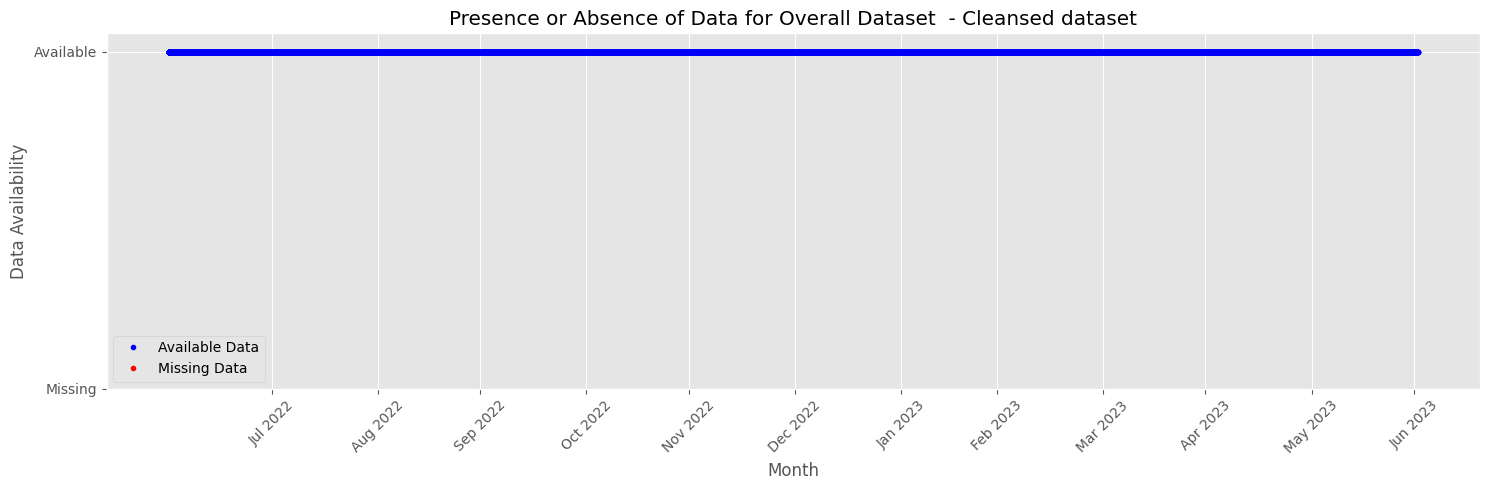

In [41]:
# Convert to pandas
cleansed_df_pd = df_tot_cleansed_n_validated.toPandas()
PlotTitle = ' - Cleansed dataset'
DataPointsVisualizer.plot_missing_data(cleansed_df_pd, PlotTitle)

In [42]:
class MissingRecordsPlotterForEachInverter:
    def __init__(self, result_df_py):
        self.result_df_pd = result_df_py.toPandas()

    def plot_missing_records(self):
        # Convert 'date_time' column to datetime if it's not already in datetime format
        self.result_df_pd['date_time'] = pd.to_datetime(self.result_df_pd['date_time'])

        # Set 'date_time' as the index of the DataFrame
        self.result_df_pd.set_index('date_time', inplace=True)

        # Calculate the expected number of records for each inverter per day (48 records per day)
        expected_records_per_day = 48

        # Group by 'inverter_serial_no' and resample to daily frequency
        grouped = self.result_df_pd.groupby('inverter_serial_no').resample('D')

        # Calculate the actual number of records for each inverter per day
        actual_records_per_day = grouped.size().unstack('inverter_serial_no')

        # Create a DataFrame with missing records (difference between expected and actual records)
        missing_records = (expected_records_per_day - actual_records_per_day).fillna(0)

        # Plotting missing records for each inverter
        plt.figure(figsize=(12, 6))
        for inverter_serial_no in missing_records.columns:
            plt.plot(missing_records.index, missing_records[inverter_serial_no], marker='o', label=f'Inverter {inverter_serial_no}')

        plt.title('Missing Records for Each Inverter')
        plt.xlabel('Date')
        plt.ylabel('Missing Records')
        plt.xticks(pd.date_range(start=missing_records.index.min(), end=missing_records.index.max(), freq='M'), [d.strftime('%b %Y') for d in pd.date_range(start=missing_records.index.min(), end=missing_records.index.max(), freq='M')], rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

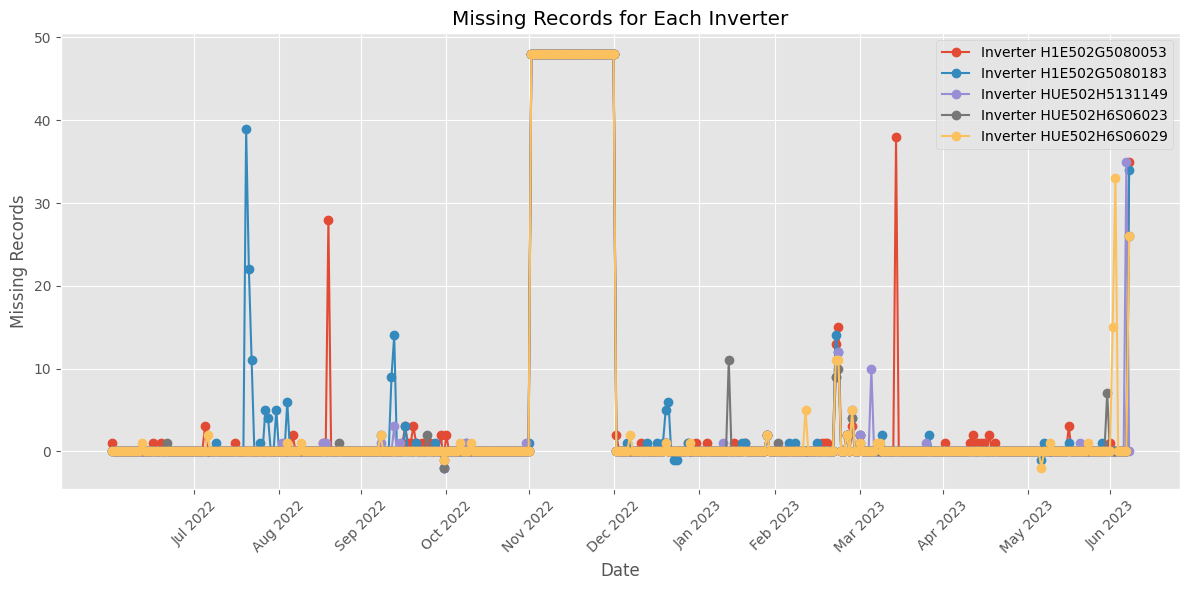

In [43]:

file_path = "/content/drive/MyDrive/MUG/FileWith5Inverters - SET II.csv"
data_handler = SQLServerDataHandler(spark)
result_df_py=data_handler.load_inverter_data(file_path) # Loading data from csv file. This will change to load data directly from DB table.


plotter = MissingRecordsPlotterForEachInverter(result_df_py)

# Plot the missing records
plotter.plot_missing_records()

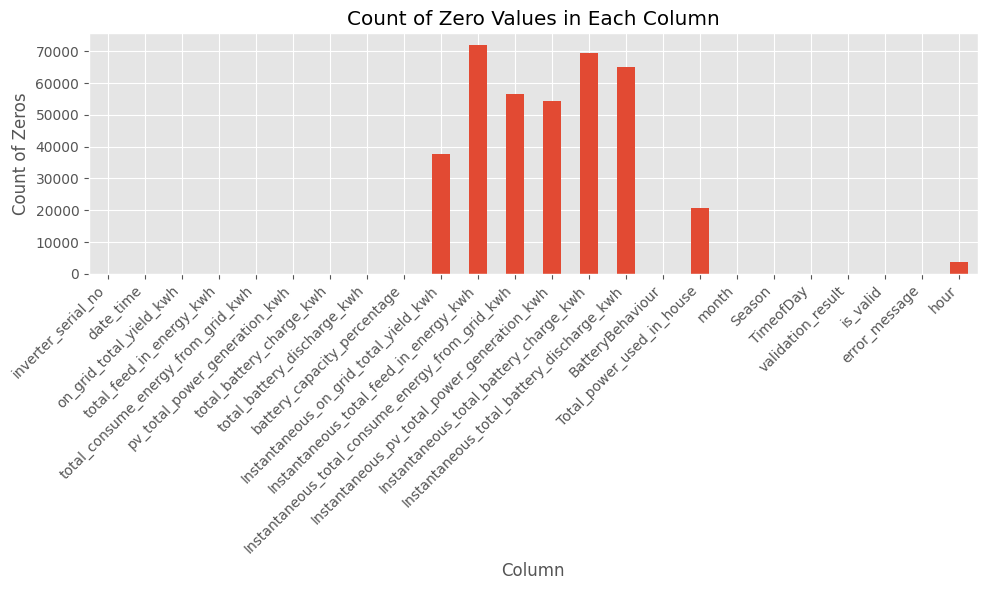

In [44]:
DataPointsVisualizer.plot_zero_counts(eda_df_pd)

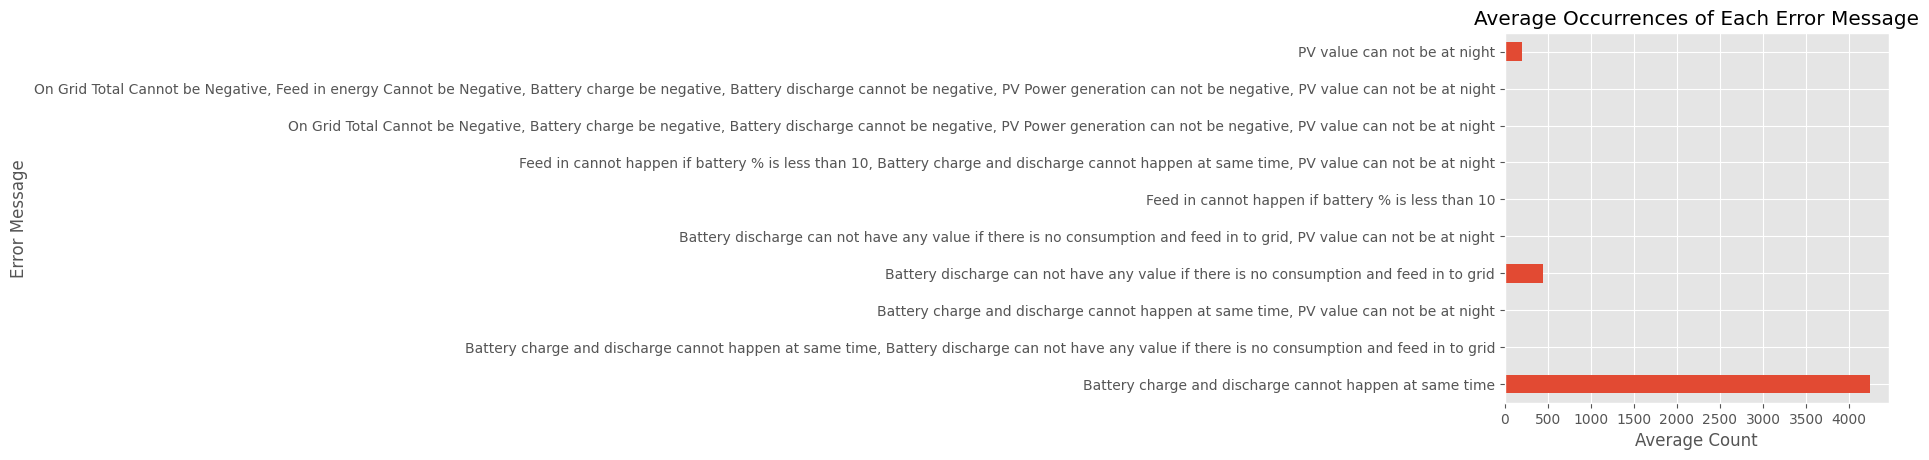

In [45]:
DataPointsVisualizer.plot_average_error_counts(df_validated)

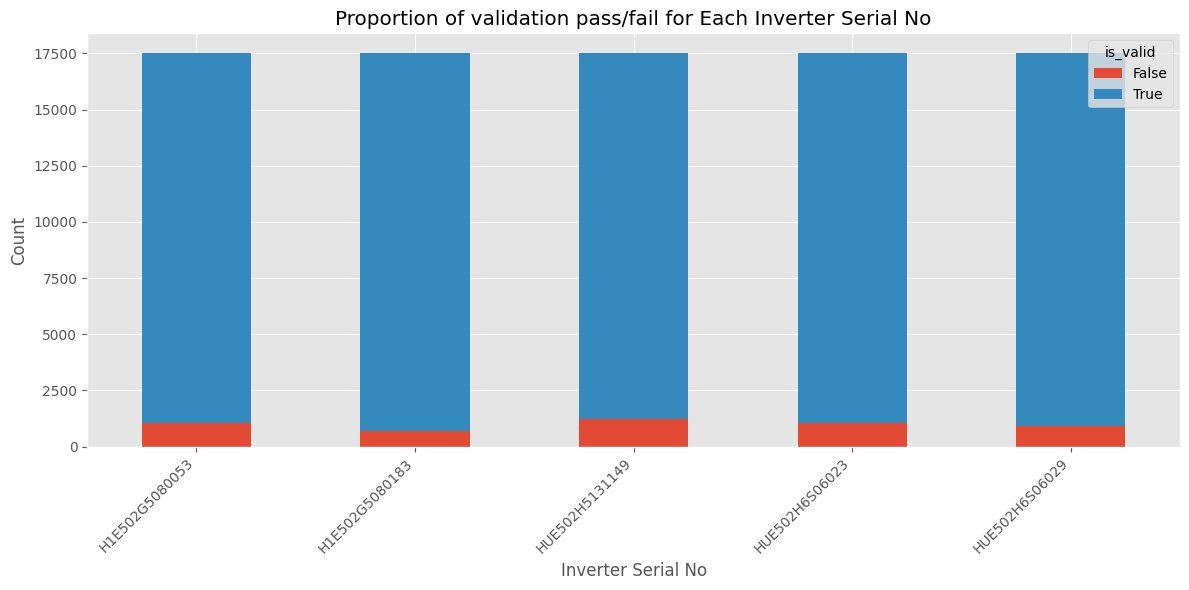

In [46]:
DataPointsVisualizer.plot_validation_proportion(df_validated)

In [47]:
class ScatterPlotGenerator:
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def generate_scatter_plots(self, columns):
        # Loop through each column and create scatter plots by inverter_serial_no
        for column in columns:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(data=self.dataframe, x='inverter_serial_no', y=column, hue='inverter_serial_no', palette='viridis')
            plt.title(f'Scatter Plot of {column} by Inverter Serial No')
            plt.xlabel('Inverter Serial No')
            plt.ylabel(column)
            plt.legend(title='Inverter Serial No')
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    def generate_pair_plot(self, columns):
        # Select the relevant columns from the DataFrame
        selected_data = self.dataframe[['inverter_serial_no'] + columns]

        # Generate the pair plot
        plt.figure(figsize=(20, 20))
        sns.pairplot(selected_data, hue='inverter_serial_no', palette='viridis')
        plt.suptitle('Pair Plot for Selected Columns by Inverter Serial No')
        plt.show()





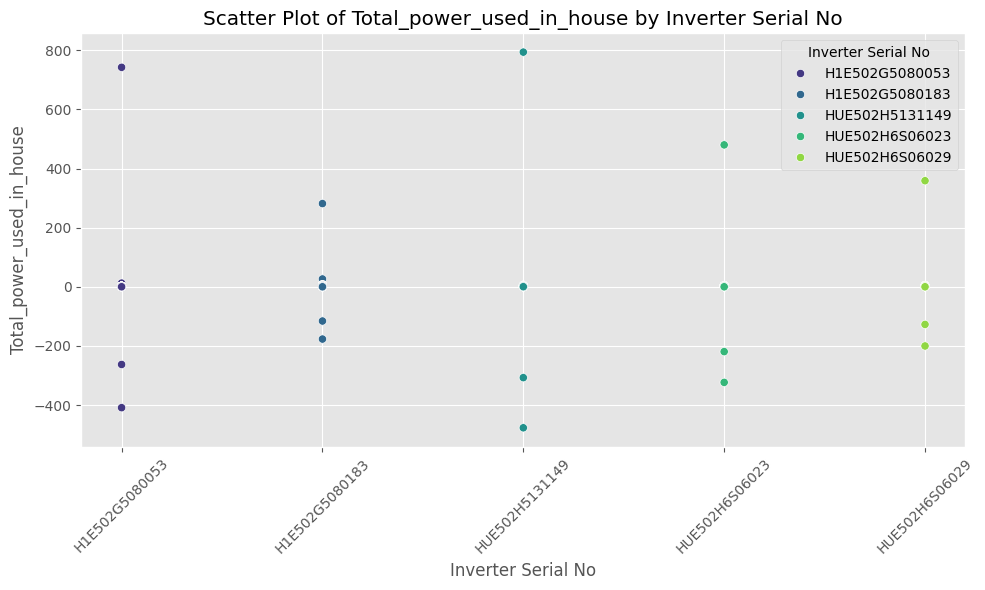

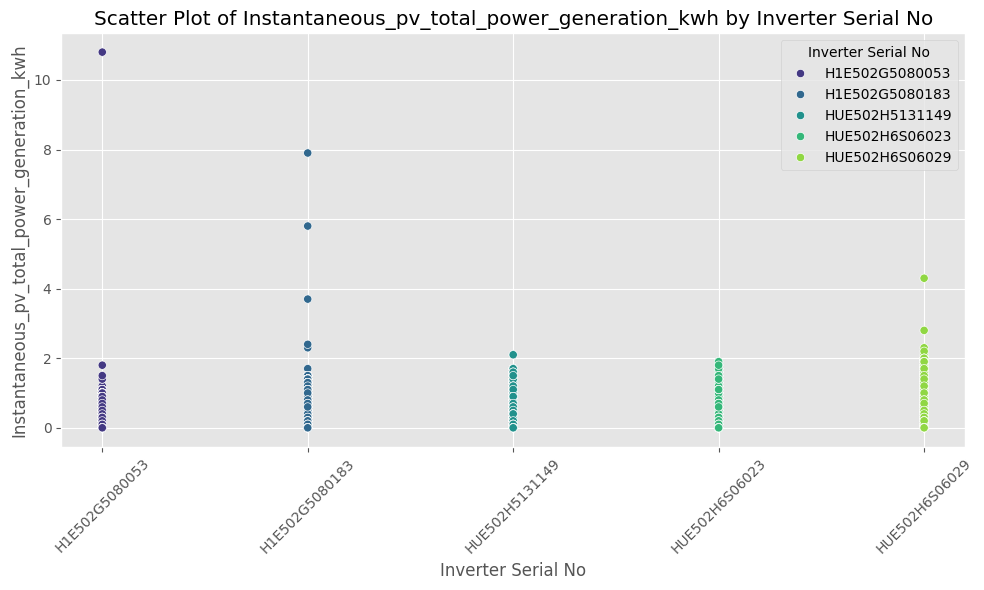

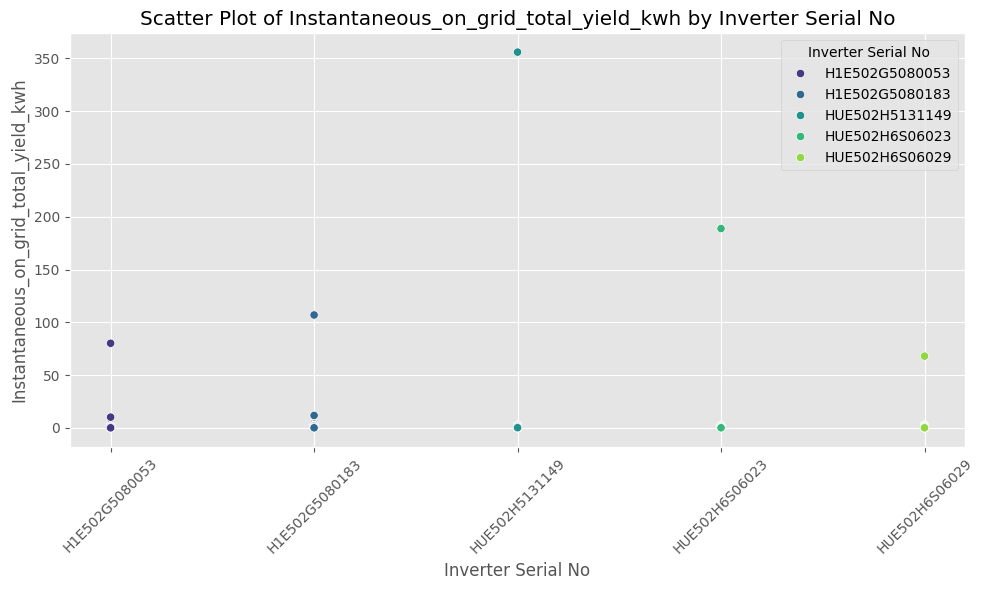

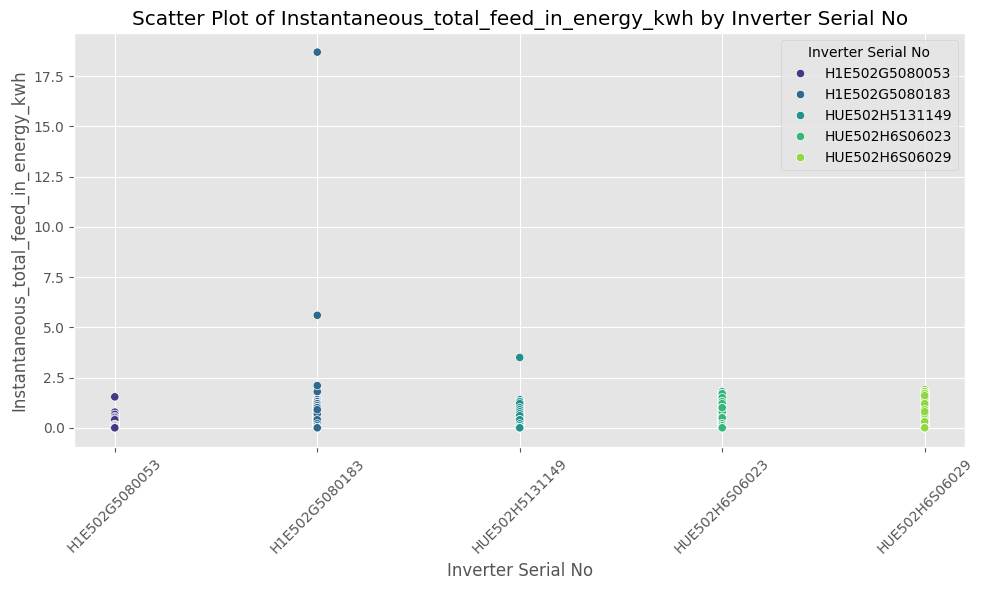

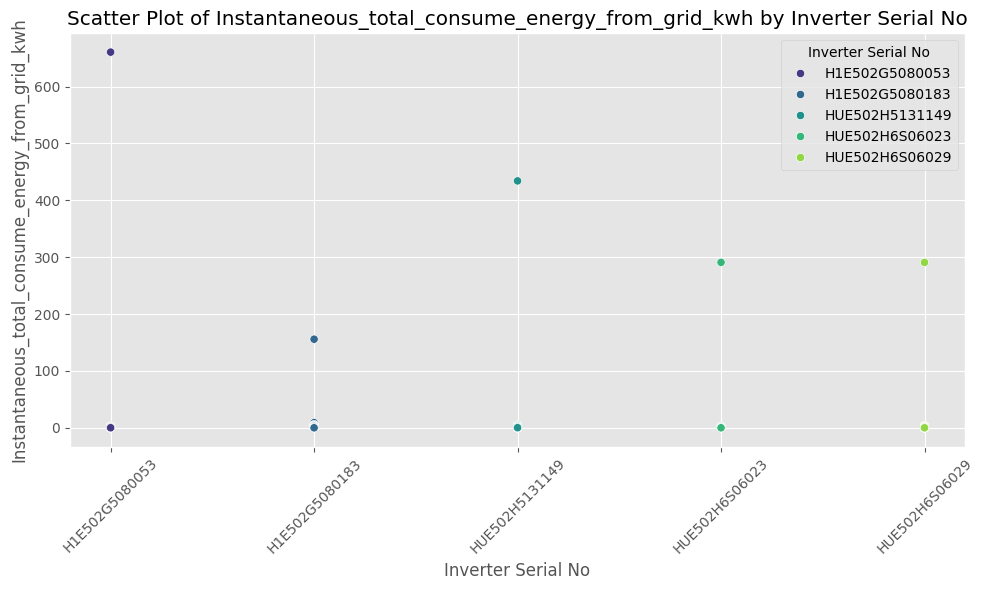

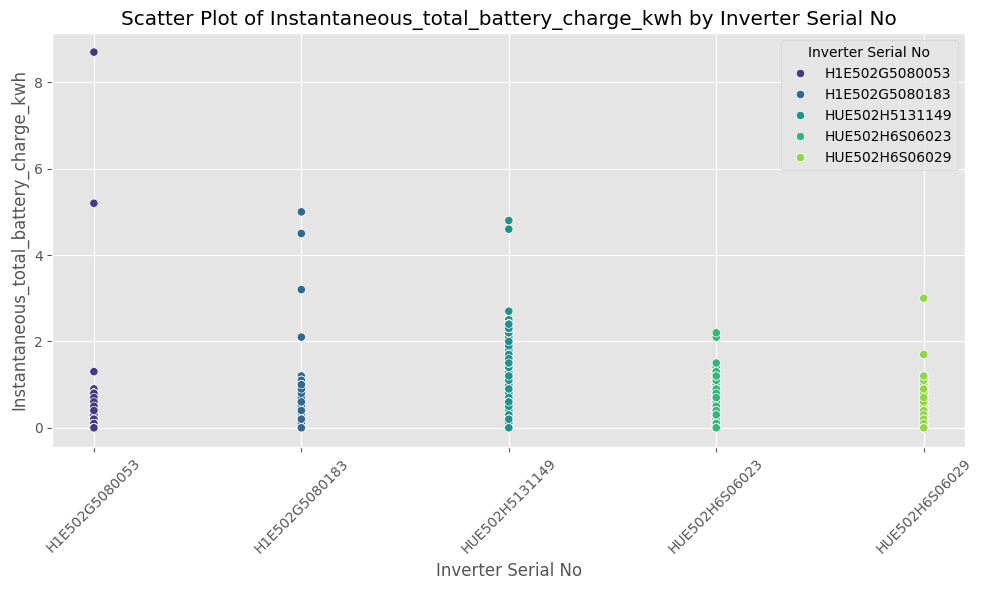

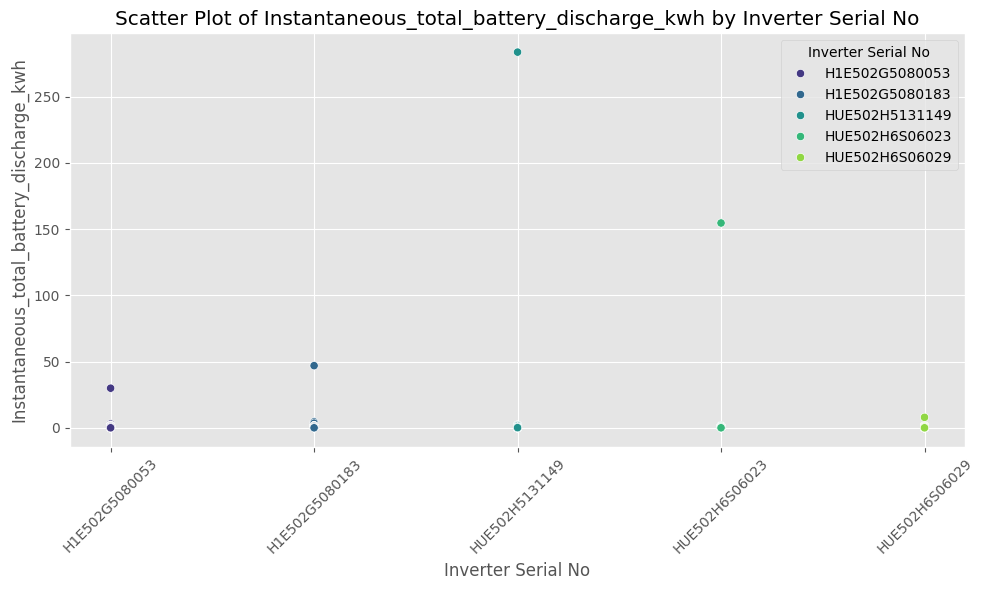

In [48]:
scatter_plot_generator = ScatterPlotGenerator(eda_df_pd)
selected_columns = [
    'Total_power_used_in_house',
    'Instantaneous_pv_total_power_generation_kwh',
    'Instantaneous_on_grid_total_yield_kwh',
    'Instantaneous_total_feed_in_energy_kwh',
    'Instantaneous_total_consume_energy_from_grid_kwh',
    'Instantaneous_total_battery_charge_kwh',
    'Instantaneous_total_battery_discharge_kwh'
]

scatter_plot_generator.generate_scatter_plots(selected_columns)

<Figure size 2000x2000 with 0 Axes>

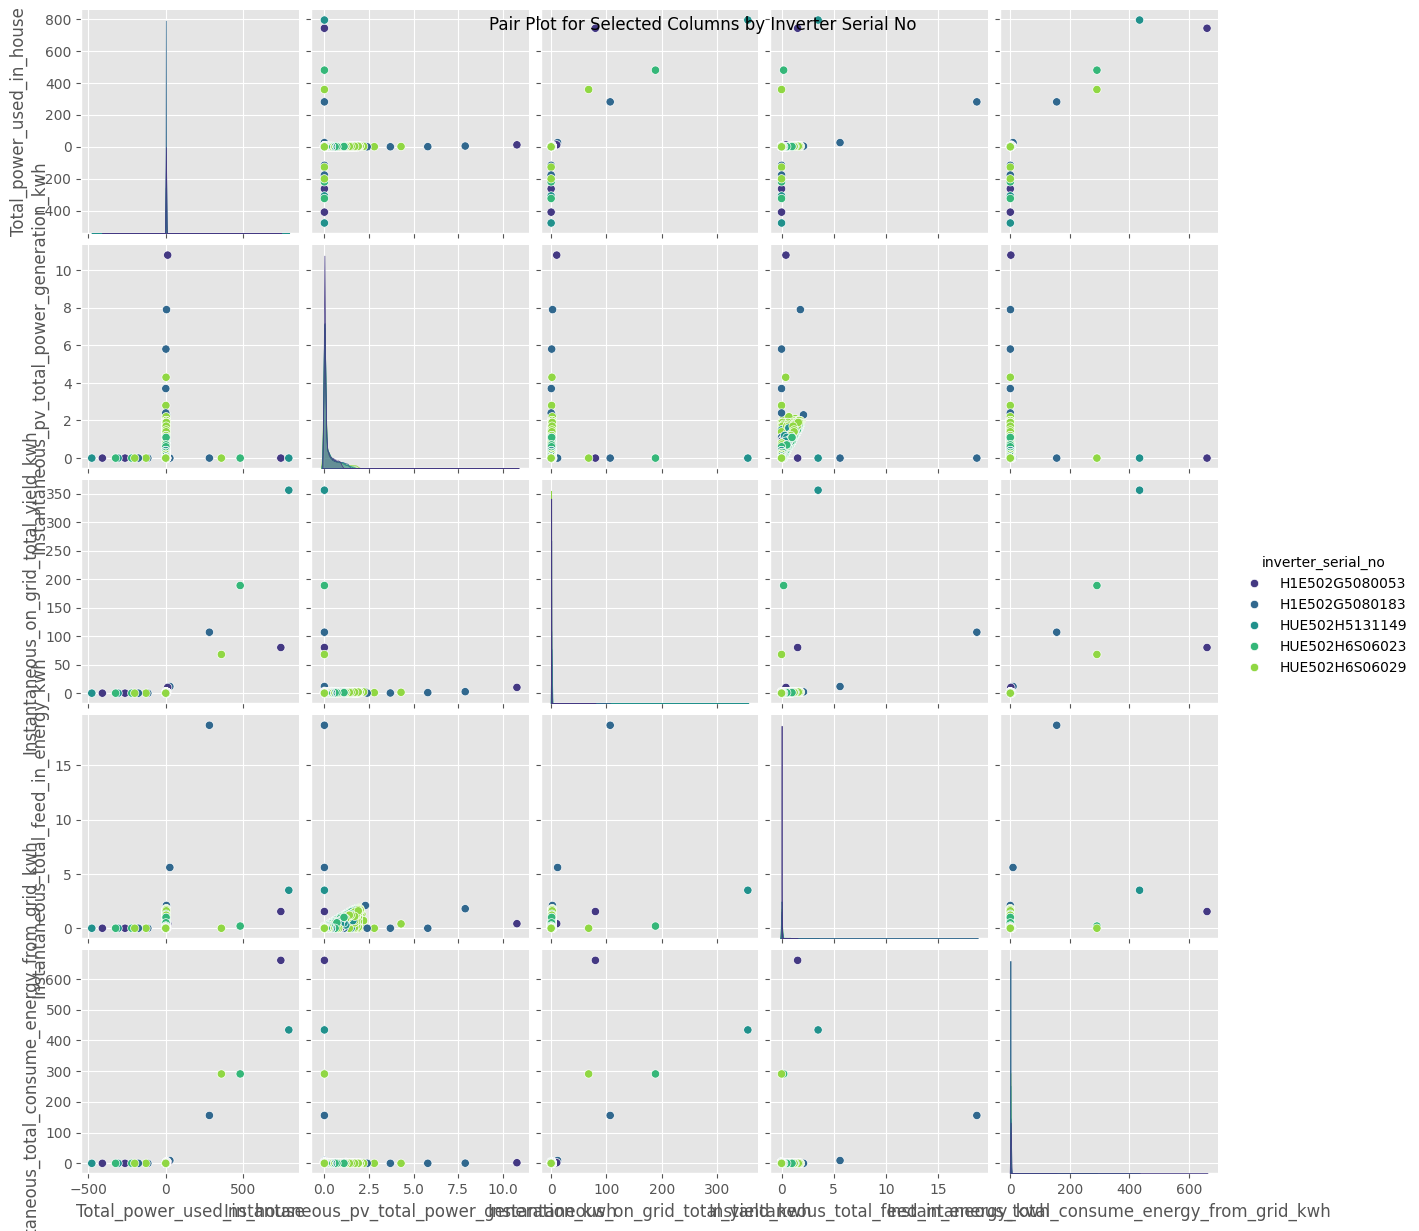

In [49]:
selected_columns_pp = [
    'Total_power_used_in_house',
    'Instantaneous_pv_total_power_generation_kwh',
    'Instantaneous_on_grid_total_yield_kwh',
    'Instantaneous_total_feed_in_energy_kwh',
    'Instantaneous_total_consume_energy_from_grid_kwh'
]
scatter_plot_generator.generate_pair_plot(selected_columns_pp)

## Proportion-wise graphs

In [50]:
class DataPropotionVisualizer:
    def __init__(self, df):
        self.df = df

    def _plot_pie_chart(self, labels, values, title, position):
        plt.subplot(1, 3, position)
        plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
        plt.title(title)

    def _aggregate_season_totals(self, column):
        return self.df.groupBy('Season').sum(column).collect()

    def plot_power_usage_pie(self):
        season_totals = self._aggregate_season_totals('Total_power_used_in_house')
        season_labels = [row['Season'] for row in season_totals]
        power_values = [row['sum(Total_power_used_in_house)'] for row in season_totals]
        self._plot_pie_chart(season_labels, power_values, 'Total Power Used in House', 1)

    def plot_power_generation_pie(self):
        season_totals = self._aggregate_season_totals('Instantaneous_pv_total_power_generation_kwh')
        season_labels = [row['Season'] for row in season_totals]
        power_values = [row['sum(Instantaneous_pv_total_power_generation_kwh)'] for row in season_totals]
        self._plot_pie_chart(season_labels, power_values, 'Total Power Generation', 2)

    def plot_feed_in_to_grid_pie(self):
        season_totals = self._aggregate_season_totals('Instantaneous_total_feed_in_energy_kwh')
        season_labels = [row['Season'] for row in season_totals]
        power_values = [row['sum(Instantaneous_total_feed_in_energy_kwh)'] for row in season_totals]
        self._plot_pie_chart(season_labels, power_values, 'Total Feed In to the Grid', 3)

    @staticmethod
    def plot_battery_usage_pie(df):
        # Aggregating total battery usage for each season
        season_totals_for_bc = df.groupBy('Season').sum('Instantaneous_total_battery_charge_kwh').collect()

        # Extracting data for the first pie chart
        season_labels_bc = [row['Season'] for row in season_totals_for_bc]
        power_values_bc = [row['sum(Instantaneous_total_battery_charge_kwh)'] for row in season_totals_for_bc]

        # Apply a style sheet
        plt.style.use('ggplot')

        # Plotting the first pie chart
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
        plt.pie(power_values_bc, labels=season_labels_bc, autopct='%1.1f%%', startangle=90)
        plt.title('Total Battery Charge')

        # Total battery discharge
        season_totals_for_bdc = df.groupBy('Season').sum('Instantaneous_total_battery_discharge_kwh').collect()

        # Extracting data for the second pie chart
        season_labels_bdc = [row['Season'] for row in season_totals_for_bdc]
        power_values_bdc = [row['sum(Instantaneous_total_battery_discharge_kwh)'] for row in season_totals_for_bdc]

        # Plotting the second pie chart
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
        plt.pie(power_values_bdc, labels=season_labels_bdc, autopct='%1.1f%%', startangle=90)
        plt.title('Total Battery Discharge')

        # Show the plot
        plt.tight_layout()
        plt.suptitle('Battery charge/discharge for Each Season', fontsize=16)

    @staticmethod
    def plot_battery_usage_timeofday(df):
        # Aggregating total battery usage for each TimeofDay
        TimeofDay_totals_for_bc = df.groupBy('TimeofDay').sum('Instantaneous_total_battery_charge_kwh').collect()

        # Extracting data for the first pie chart
        TimeofDay_labels_bc = [row['TimeofDay'] for row in TimeofDay_totals_for_bc]
        power_values_bc_TimeofDay = [row['sum(Instantaneous_total_battery_charge_kwh)'] for row in TimeofDay_totals_for_bc]

        # Apply a style sheet
        plt.style.use('ggplot')

        # Plotting the first pie chart
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
        plt.pie(power_values_bc_TimeofDay, labels=TimeofDay_labels_bc, autopct='%1.1f%%', startangle=90)
        plt.title('Total Battery Charge')

        # Total battery discharge
        TimeofDay_totals_for_bdc = df.groupBy('TimeofDay').sum('Instantaneous_total_battery_discharge_kwh').collect()

        # Extracting data for the second pie chart
        TimeofDay_labels_bdc = [row['TimeofDay'] for row in TimeofDay_totals_for_bdc]
        power_values_bdc_TimeofDay = [row['sum(Instantaneous_total_battery_discharge_kwh)'] for row in TimeofDay_totals_for_bdc]

        # Plotting the second pie chart
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
        plt.pie(power_values_bdc_TimeofDay, labels=TimeofDay_labels_bdc, autopct='%1.1f%%', startangle=90)
        plt.title('Total Battery Discharge')

        # Show the plot
        plt.tight_layout()
        plt.suptitle('Battery charge/discharge across a Day', fontsize=16)

    @staticmethod
    def plot_power_patterns_by_time_of_day(df):
        # Aggregating total power usage for each TimeofDay
        TimeofDay_totals_usage = df.groupBy('TimeofDay').sum('Total_power_used_in_house').collect()

        # Extracting data for the first pie chart
        TimeofDay_labels_usage = [row['TimeofDay'] for row in TimeofDay_totals_usage]
        power_values_TimeofDay_usage = [row['sum(Total_power_used_in_house)'] for row in TimeofDay_totals_usage]

        # Plotting the first pie chart
        plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
        plt.pie(power_values_TimeofDay_usage, labels=TimeofDay_labels_usage, autopct='%1.1f%%', startangle=90)
        plt.title('Total Power Used')
        plt.style.use('ggplot')

        # Aggregating total feed-in to the grid for each TimeofDay
        TimeofDay_totals_feedIn = df.groupBy('TimeofDay').sum('Instantaneous_total_feed_in_energy_kwh').collect()

        # Extracting data for the second pie chart
        TimeofDay_labels_feedIn = [row['TimeofDay'] for row in TimeofDay_totals_feedIn]
        power_values_TimeofDay_feedIn = [row['sum(Instantaneous_total_feed_in_energy_kwh)'] for row in TimeofDay_totals_feedIn]

        # Plotting the second pie chart
        plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
        plt.pie(power_values_TimeofDay_feedIn, labels=TimeofDay_labels_feedIn, autopct='%1.1f%%', startangle=90)
        plt.title('Total Feed In to the Grid')
        plt.style.use('ggplot')

        # Aggregating total power generation for each TimeofDay
        TimeofDay_totals_powerGen = df.groupBy('TimeofDay').sum('Instantaneous_pv_total_power_generation_kwh').collect()

        # Extracting data for the third pie chart
        TimeofDay_labels_powerGen = [row['TimeofDay'] for row in TimeofDay_totals_powerGen]
        power_values_TimeofDay_powerGen = [row['sum(Instantaneous_pv_total_power_generation_kwh)'] for row in TimeofDay_totals_powerGen]

        # Plotting the third pie chart
        plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
        plt.pie(power_values_TimeofDay_powerGen, labels=TimeofDay_labels_powerGen, autopct='%1.1f%%', startangle=90)
        plt.title('Total Power Generated')
        plt.style.use('ggplot')

        # Show the plot
        plt.tight_layout()
        plt.suptitle('Energy patterns across Time of Day', fontsize=16)


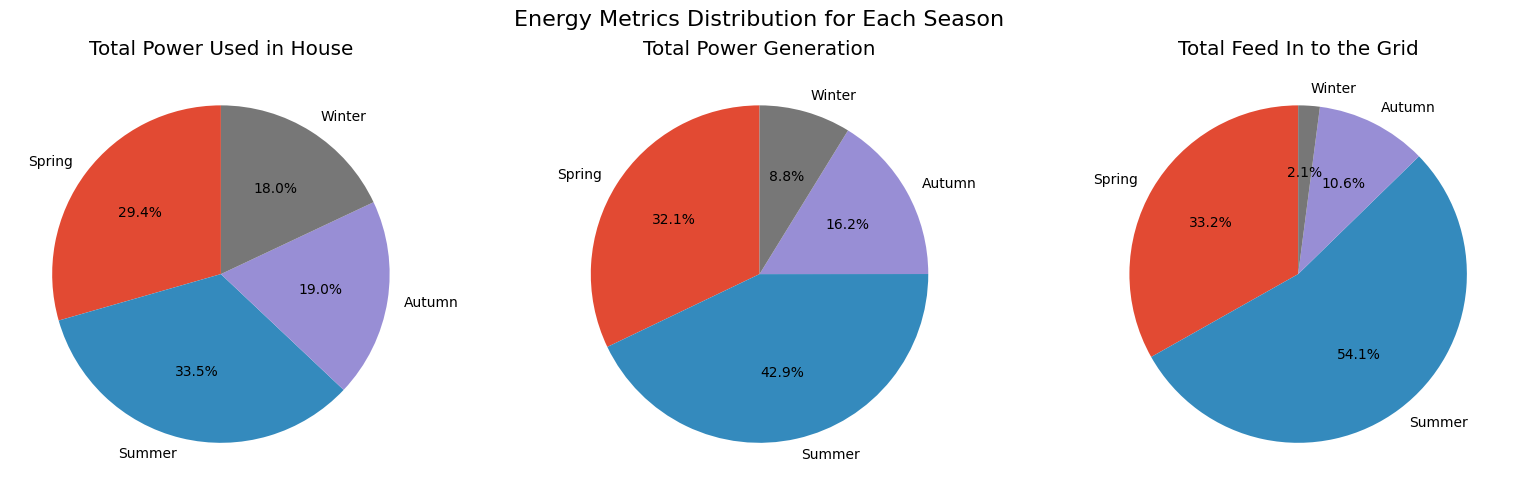

In [51]:
visualizer = DataPropotionVisualizer(df_tot_cleansed_n_validated)
plt.figure(figsize=(16, 5))
visualizer.plot_power_usage_pie()
visualizer.plot_power_generation_pie()
visualizer.plot_feed_in_to_grid_pie()
plt.suptitle('Energy Metrics Distribution for Each Season', fontsize=16)
plt.style.use('ggplot')
plt.tight_layout()
plt.show()

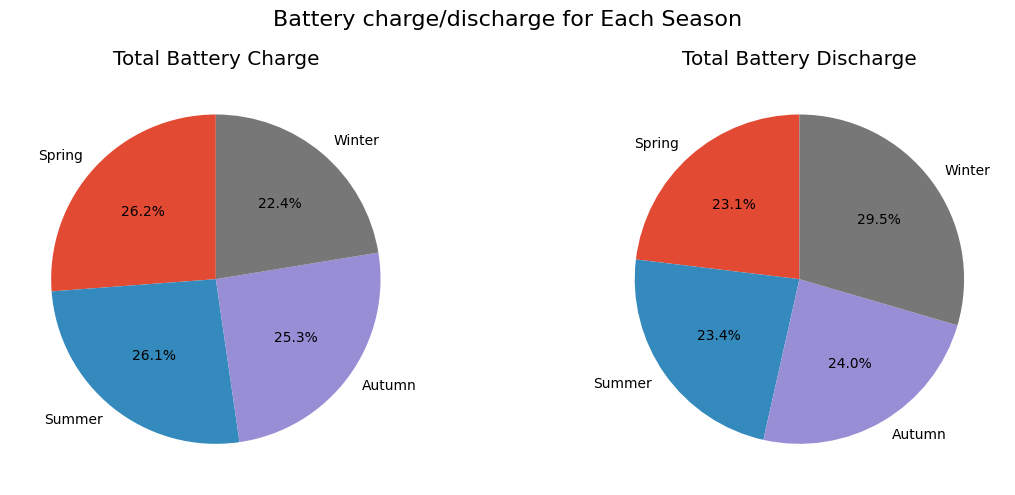

In [52]:
plt.figure(figsize=(16, 5))
visualizer = DataPropotionVisualizer(df_tot_cleansed_n_validated)
visualizer.plot_battery_usage_pie(df_tot_cleansed_n_validated)
plt.tight_layout()  # Adjusted the layout call
plt.show()

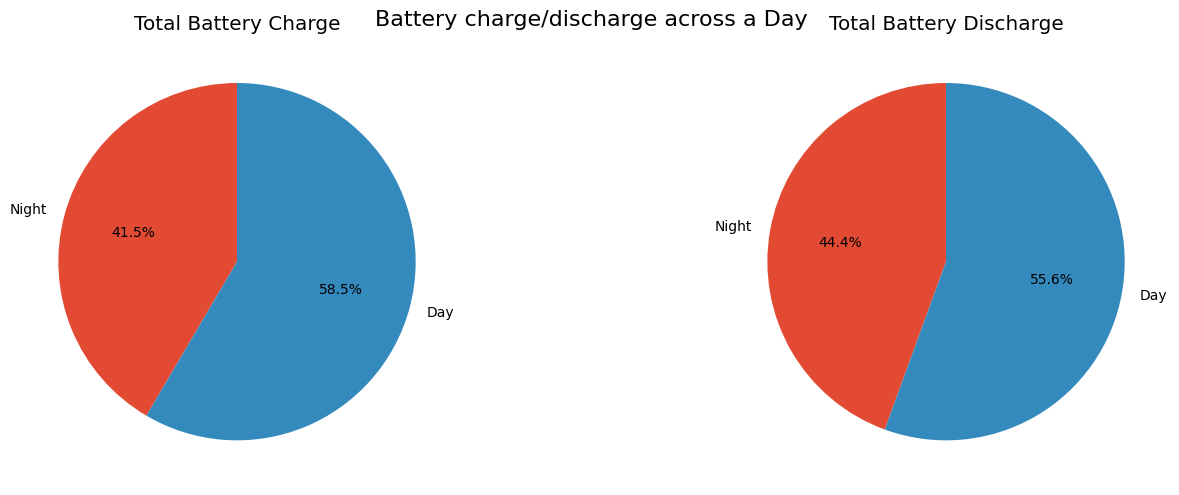

In [53]:
plt.figure(figsize=(16, 5))
visualizer = DataPropotionVisualizer(df_tot_cleansed_n_validated)
visualizer.plot_battery_usage_timeofday(df_tot_cleansed_n_validated)
plt.style.use('ggplot')
plt.show()

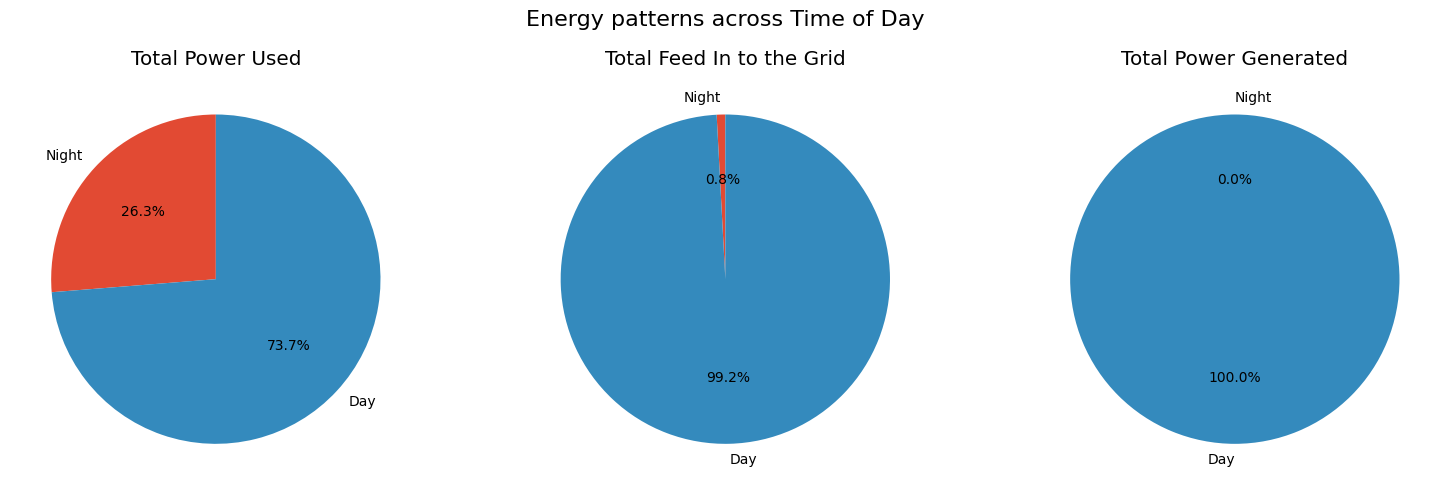

In [54]:
plt.figure(figsize=(16, 5))
visualizer = DataPropotionVisualizer(df_tot_cleansed_n_validated)
visualizer.plot_power_patterns_by_time_of_day(df_tot_cleansed_n_validated)
plt.tight_layout()
plt.show()

## Trends

### Hourly Distribution

In [55]:
class HourlyEnergyPlotter:
    def __init__(self, df):
        self.df = df

    def _plot_hourly_data(self, columns, ylabel):
        plt.figure(figsize=(12, 4))

        for column in columns:
            hourly_totals = self.df.groupby('hour')[column].sum()
            hourly_totals.plot(marker='o', linestyle='-', label=column)

        plt.title('Hourly Distribution of '+ plotTitle)
        plt.xlabel('Hour of the Day')
        plt.ylabel(ylabel)
        plt.xticks(range(24))
        plt.legend()
        plt.grid(True)
        plt.style.use('ggplot')

        # Adjust layout for better spacing
        plt.tight_layout()

        # Show the plot
        plt.show()

    def plot_hourly_energy_distribution(self, columns, plotTitle):
        self._plot_hourly_data(columns, 'Energy (kWh)')

    def plot_hourly_battery_charge_discharge(self, columns, plotTitle):
        self._plot_hourly_data(columns, 'Battery Energy (kWh)')

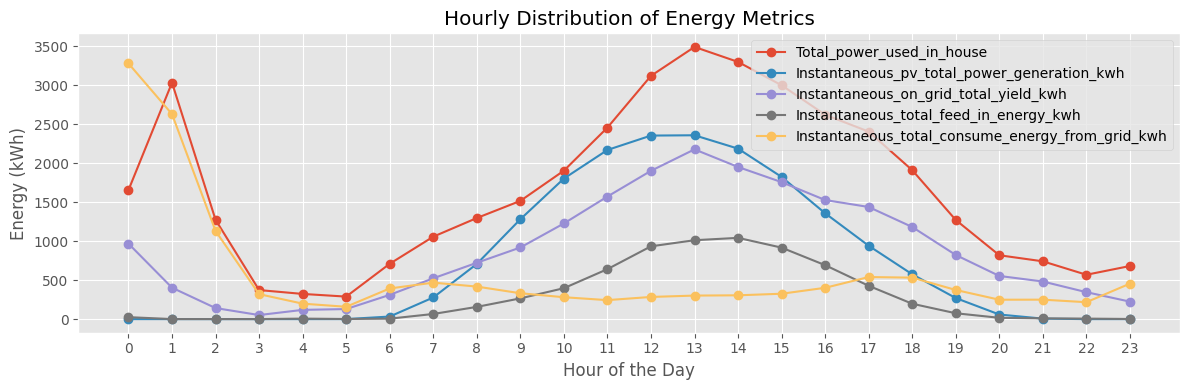

In [56]:
# Create an instance of HourlyEnergyPlotter
plotter = HourlyEnergyPlotter(eda_df_pd)

# Define the list of columns to aggregate for energy distribution
energy_columns = [
    'Total_power_used_in_house',
    'Instantaneous_pv_total_power_generation_kwh',
    'Instantaneous_on_grid_total_yield_kwh',
    'Instantaneous_total_feed_in_energy_kwh',
    'Instantaneous_total_consume_energy_from_grid_kwh'
]

# Plot hourly energy distribution
plotTitle = 'Energy Metrics'
plotter.plot_hourly_energy_distribution(energy_columns, plotTitle)

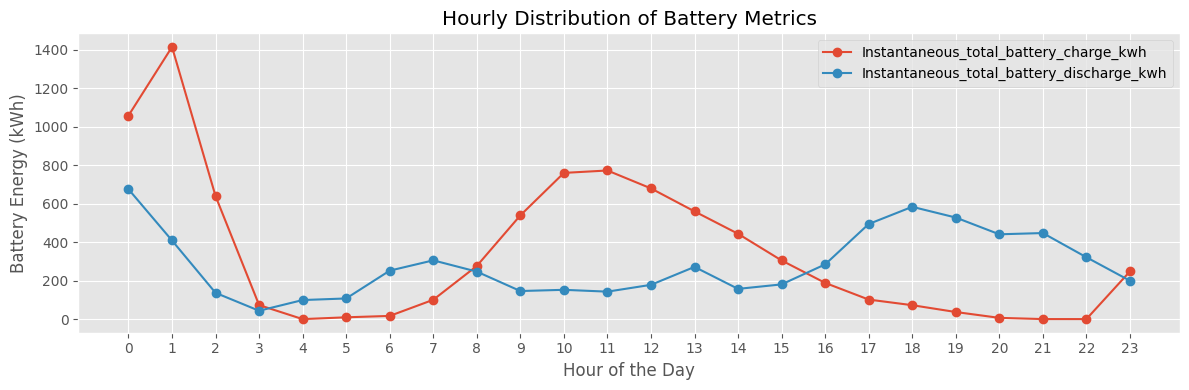

In [57]:
# Create an instance of HourlyEnergyPlotter
plotter = HourlyEnergyPlotter(eda_df_pd)

# Define the list of columns to aggregate for battery charge/discharge
battery_columns = [
    'Instantaneous_total_battery_charge_kwh',
    'Instantaneous_total_battery_discharge_kwh'
]

# Plot hourly battery charge/discharge
plotTitle = 'Battery Metrics'
plotter.plot_hourly_battery_charge_discharge(battery_columns, plotTitle)

### Daily Distribution

In [58]:
class EnergyDistributionAcrossWeekPlotter:
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def plot_energy_distribution(self, columns_to_analyze, title):
        # Convert 'date_time' column to datetime if it's not already in datetime format
        self.dataframe['date_time'] = pd.to_datetime(self.dataframe['date_time'])

        # Extract the day of the week (Monday=0, Sunday=6)
        self.dataframe['day_of_week'] = self.dataframe['date_time'].dt.dayofweek

        # Group by day of the week and calculate the mean of the specified columns
        grouped = self.dataframe.groupby('day_of_week')[columns_to_analyze].mean()

        # Define the days of the week
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

        # Plotting the distribution of each column for each day of the week
        plt.figure(figsize=(12, 8))
        for column in columns_to_analyze:
            plt.plot(days, grouped[column], marker='o', label=column)

        plt.title(title)
        plt.xlabel('Day of the Week')
        plt.ylabel('Average Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



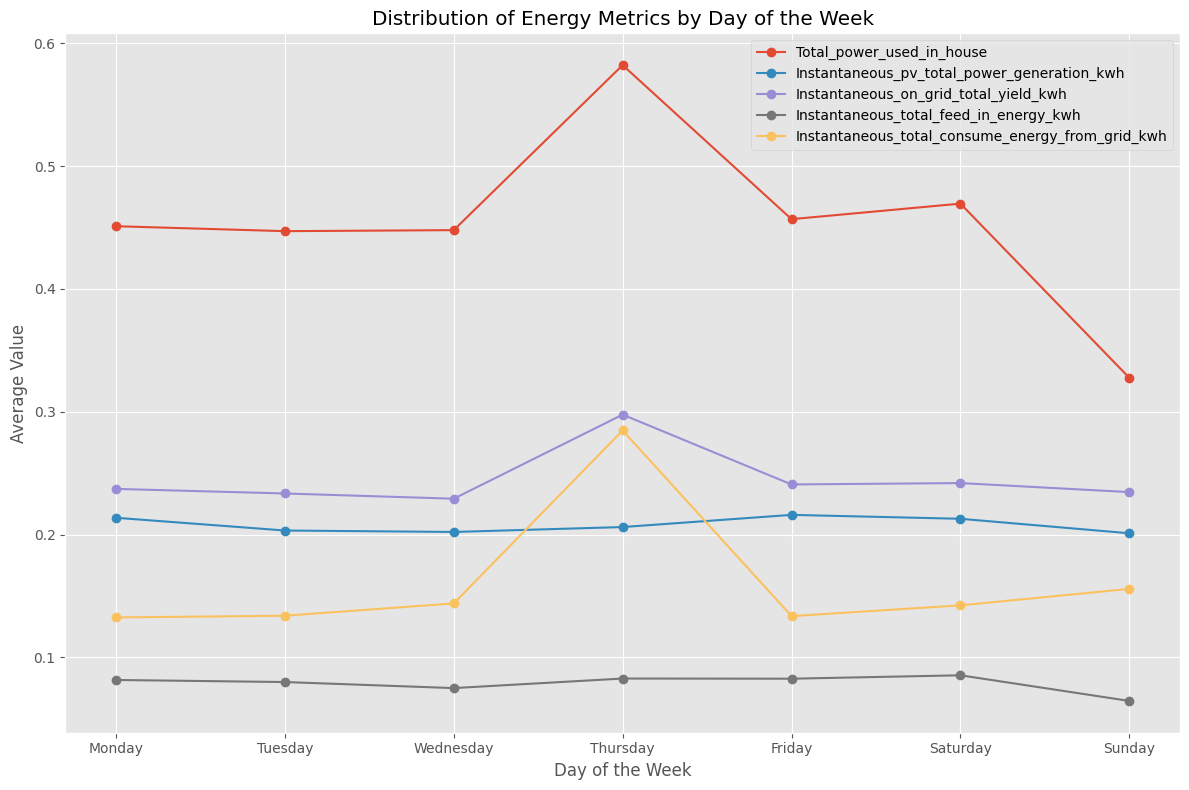

In [59]:
# Example usage for energy metrics
energy_distribution_plotter = EnergyDistributionAcrossWeekPlotter(eda_df_pd)
columns_to_analyze = [
    'Total_power_used_in_house',
    'Instantaneous_pv_total_power_generation_kwh',
    'Instantaneous_on_grid_total_yield_kwh',
    'Instantaneous_total_feed_in_energy_kwh',
    'Instantaneous_total_consume_energy_from_grid_kwh'
]
energy_distribution_plotter.plot_energy_distribution(columns_to_analyze, 'Distribution of Energy Metrics by Day of the Week')



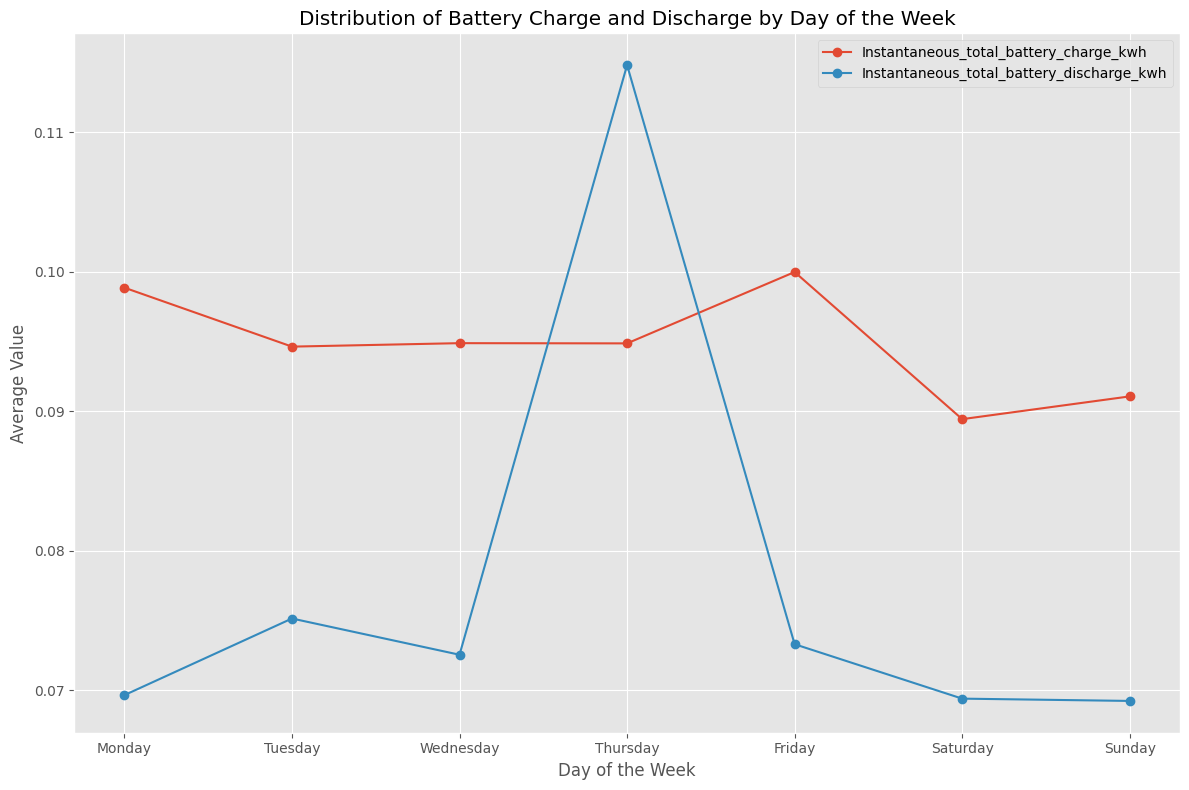

In [60]:
# Example usage for battery metrics
battery_distribution_plotter = EnergyDistributionAcrossWeekPlotter(eda_df_pd)
columns_to_analyze_battery = [
    'Instantaneous_total_battery_charge_kwh',
    'Instantaneous_total_battery_discharge_kwh'
]
battery_distribution_plotter.plot_energy_distribution(columns_to_analyze_battery, 'Distribution of Battery Charge and Discharge by Day of the Week')


### Monthly Distribution

In [61]:
class EnergyDistributionAcrossMonthPlotter:
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def plot_energy_distribution(self, columns_to_analyze, title):
        # Convert 'date_time' column to datetime if it's not already in datetime format
        self.dataframe['date_time'] = pd.to_datetime(self.dataframe['date_time'])

        # Extract the month from the 'date_time' column
        self.dataframe['month'] = self.dataframe['date_time'].dt.month

        # Group by month and calculate the mean of the specified columns
        grouped = self.dataframe.groupby('month')[columns_to_analyze].mean()

        # Define the months
        months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

        # Plotting the distribution of each column for each month
        plt.figure(figsize=(12, 8))
        for column in columns_to_analyze:
            plt.plot(months, grouped[column], marker='o', label=column)

        plt.title(title)
        plt.xlabel('Month')
        plt.ylabel('Average Value')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

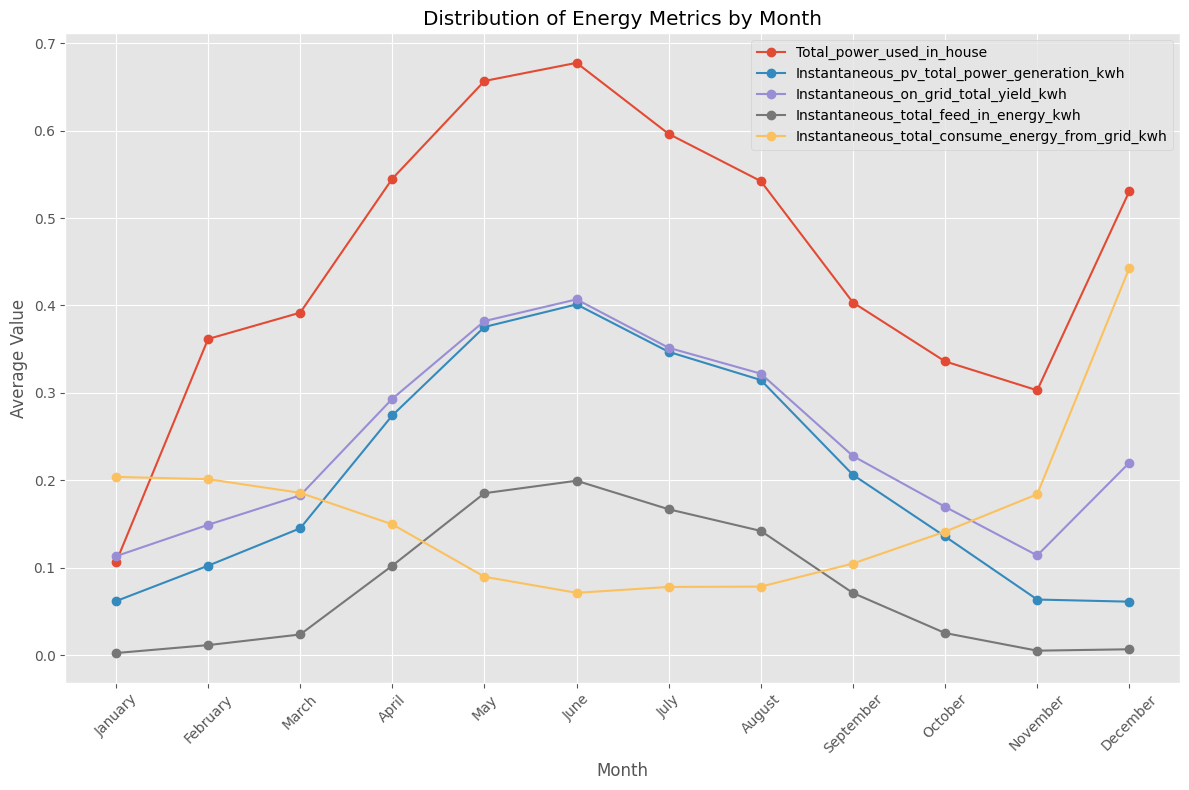

In [62]:
# Example usage
energy_distribution_plotter = EnergyDistributionAcrossMonthPlotter(eda_df_pd)
columns_to_analyze = [
    'Total_power_used_in_house',
    'Instantaneous_pv_total_power_generation_kwh',
    'Instantaneous_on_grid_total_yield_kwh',
    'Instantaneous_total_feed_in_energy_kwh',
    'Instantaneous_total_consume_energy_from_grid_kwh'
]
energy_distribution_plotter.plot_energy_distribution(columns_to_analyze, 'Distribution of Energy Metrics by Month')

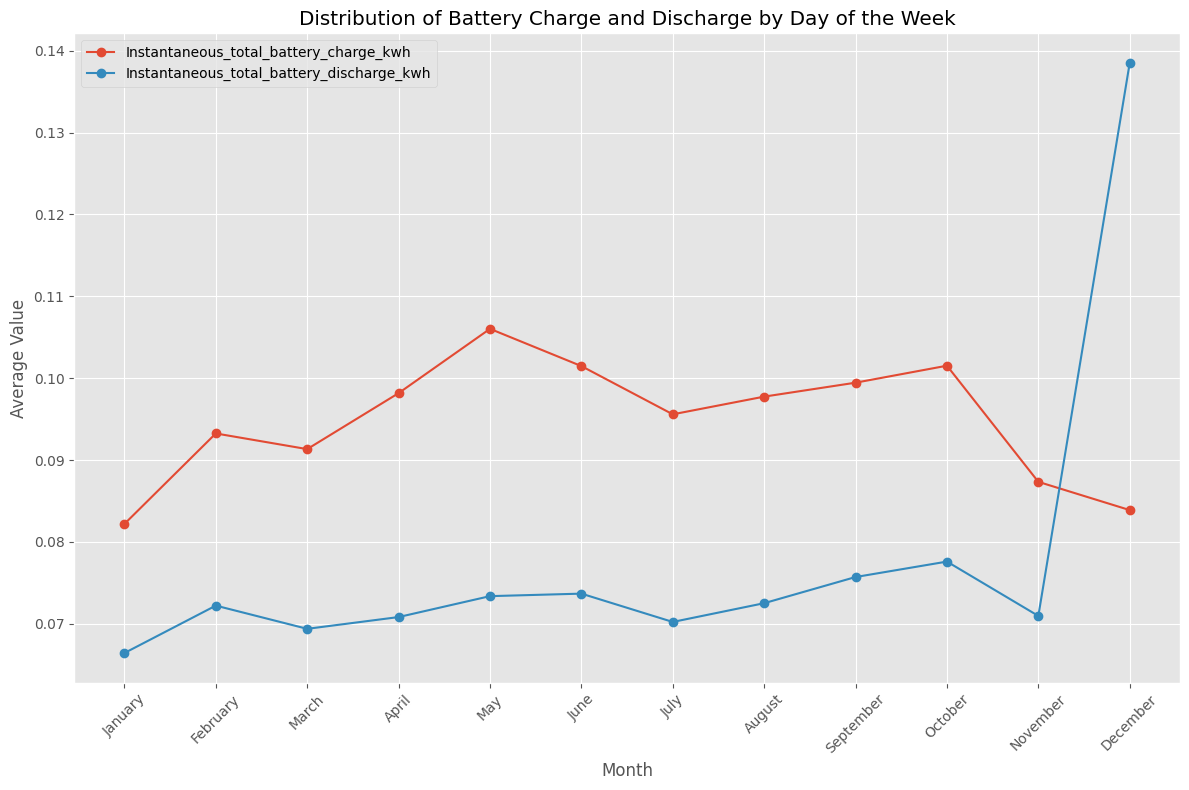

In [63]:
# Example usage for battery metrics
battery_distribution_plotter_monthly = EnergyDistributionAcrossMonthPlotter(eda_df_pd)
columns_to_analyze_battery = [
    'Instantaneous_total_battery_charge_kwh',
    'Instantaneous_total_battery_discharge_kwh'
]
battery_distribution_plotter_monthly.plot_energy_distribution(columns_to_analyze_battery, 'Distribution of Battery Charge and Discharge by Day of the Week')

## Relationships

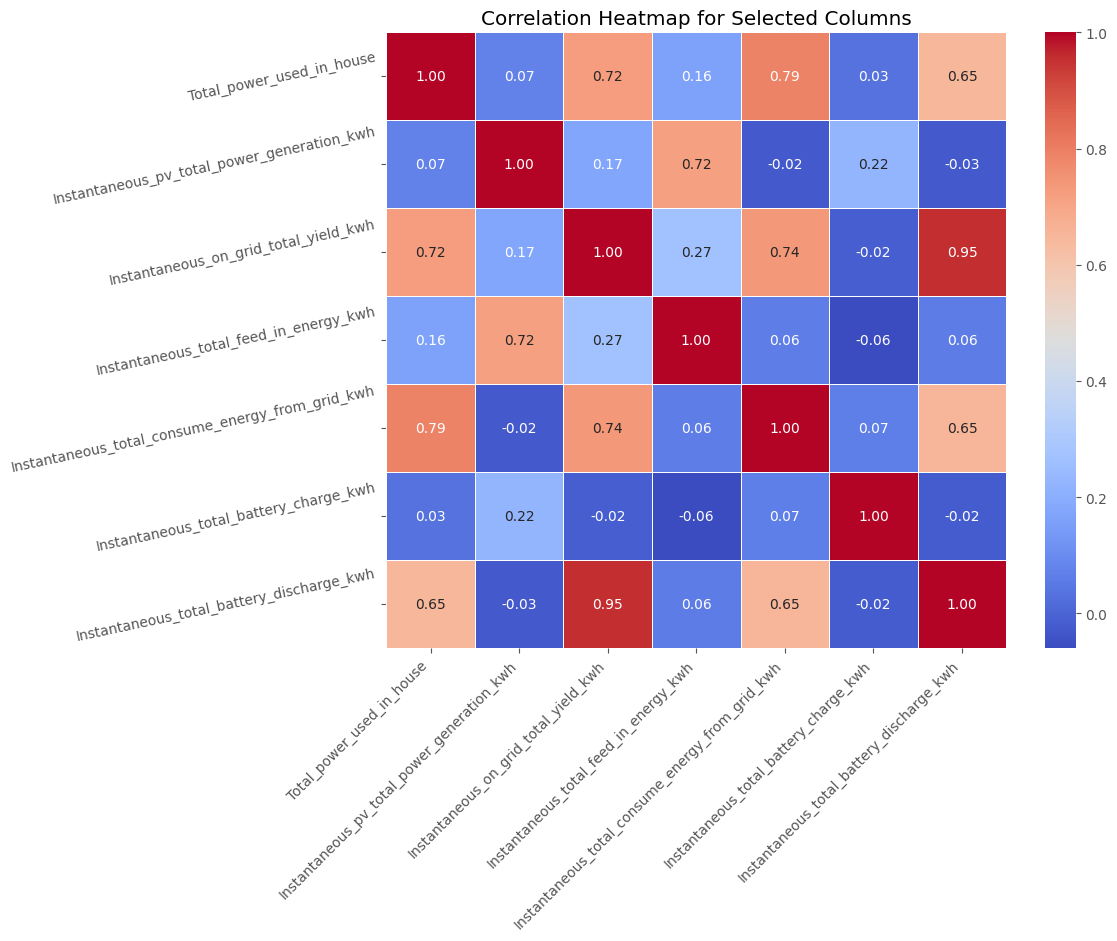

In [64]:
class CorrelationHeatmapGenerator:
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def generate_heatmap(self, selected_columns):
        # Create a correlation matrix
        correlation_matrix = self.dataframe[selected_columns].corr()

        # Generate a heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Heatmap for Selected Columns')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
        plt.yticks(rotation=12, ha='right')  # Rotate y-axis labels for better readability
        plt.show()

# Example usage
heatmap_generator = CorrelationHeatmapGenerator(eda_df_pd)
selected_columns = [
    'Total_power_used_in_house',
    'Instantaneous_pv_total_power_generation_kwh',
    'Instantaneous_on_grid_total_yield_kwh',
    'Instantaneous_total_feed_in_energy_kwh',
    'Instantaneous_total_consume_energy_from_grid_kwh',
    'Instantaneous_total_battery_charge_kwh',
    'Instantaneous_total_battery_discharge_kwh'
]
heatmap_generator.generate_heatmap(selected_columns)
